
 <img src="https://javier.rodriguez.org.mx/itesm/2014/tecnologico-de-monterrey-blue.png" alt="Paris" class="center"> 

<h1><center>Machine Learning</center></h1>
<h2><center>Assignment 2: Data Conditioning</center></h2>

<h3><center> Andree Vela</center></h3>
<h3><center> Miguel Lara</center></h3>




# Data Collection and Cleaning #

To begin, it is required to import the libraries that will be used in the analysis of the data. **Numpy and Pandas** are used to manipulate easily the data frames. **Matplotlib and seaborn** are used to plot the graphs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In the following lines the data frame **grouped** is created. The data set is pulled from the github repository and then grouped by hod (hour of death) and cod (cause of death). Then, the variable **freq** is computed by the count of people that died in each specific combine index of hod and cod. Also, the dataset is cleaned by dropping numbers in hod column that does not correspond to a real hour. At the end, the Multi-index is moved inside the data frame but the index column is removed because it does not provide any added value.


In [2]:
grouped = pd.read_csv( 'https://github.com/hadley/mexico-mortality/blob/master/deaths/deaths08.csv.bz2?raw=true', compression='bz2' )
grouped = grouped.groupby( [ 'hod', 'cod' ] )[ 'sex' ].count().rename( 'freq' ).reset_index()
grouped.drop( grouped[ ( grouped[ 'hod' ] == 99 ) | ( grouped[ 'hod' ] == 0 ) ].index, axis=0, inplace=True  )
grouped[ 'hod' ] = grouped[ 'hod' ].replace( 24, 0 ) 
grouped = grouped.reset_index()
del grouped[ 'index' ]

Later, the **grouped** data frame is updated. The information about the name of the cod (cause of death) is pulled from another dataset that is located in a github repository. The datasets are merged but only keeping the instances of **grouped** data frame. In other words, the length of the **grouped** data frame is not changed, instead a new column is added to the data frame with the name of each cod. 

In [3]:
icd_df = pd.read_csv( "https://raw.githubusercontent.com/hadley/mexico-mortality/master/disease/icd-main.csv" )
icd_df = icd_df.drop_duplicates( 'code' )
icd_df = icd_df.rename( columns = { 'code': 'cod' } )
grouped = pd.merge( grouped, icd_df, on = 'cod', how = 'left' )

# Data Computation (prop, freq_all, prop_all) #

Three new columns are added to the **grouped** data frame. The columns are computed by using the information of the data frame. Each new value computed is added to each instance of the data frame. 

***prop*** column is the ratio of the number of deaths for a specific disease that happened in one hour and the total number of deaths of the same disease in the complete span of 24hrs. Example: 300 persons died of Amebiasis at 1pm / 1000 persons died of Amebiasis in the span of 24hrs. 

***freq_all*** column is the total number of deaths that happened at a specific hour. Example: 24000 persons died at 4am. 

***prop_all*** column is the ratio of ***freq_all*** and the sum of all the deaths in the span of 24hrs. Example: 2500 persons died at 5pm / 500,000 all the persons of the data set. 

In [4]:
grouped[ 'prop' ] =   grouped[ 'freq' ] / grouped.groupby( 'cod' )[ 'freq' ].transform( 'sum')
grouped[ 'freq_all' ] =  grouped.groupby( 'hod' )[ 'freq' ].transform( 'sum')
grouped[ 'prop_all' ] =   grouped[ 'freq_all' ] / grouped[ 'freq' ].sum()


# Plot Number of Deaths by Hour #

The purpose of the following code is to show the amount of persons that died during each hour of the day. To make this possible is was neccessary to compute the number of deaths at a specific hour (***deathsbyHour***). It can be seen three peaks around 6am, 10am and 6pm, meaning that people is more like to die at these hours. 

[(18000, 25000)]

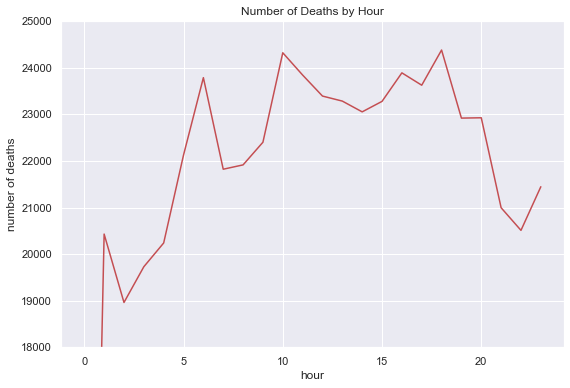

In [5]:
deathsByHour = grouped.groupby( 'hod' )[ 'freq' ].sum().rename( 'deaths' ).reset_index()

sns.set( rc={ 'figure.figsize':( 10, 4 ) } )
fig, ax = plt.subplots( figsize=(9,6) )
ax.plot( deathsByHour[ 'hod' ] , deathsByHour[ 'deaths' ], 'r')

ax.set_xlabel('hour')
ax.set_ylabel('number of deaths')
ax.set_title('Number of Deaths by Hour')
ax.set( ylim=[ 18000, 25000 ] )

# Data Computation (Deviation) #
The following code is used to compute the mean square deviation between ***prop*** and ***prop_all***. The idea of this computation is to know how far the proportion of a disease at a specific hour is from the proportion of all the deaths at that specific hour. Example: Ambiasis proportion of deaths at 2pm is 0.0034, and the proportion of all deaths at 2pm is 0.00521. There might be diseases that have a different pattern than all of the other diseases. 

In [6]:
devi = grouped.copy()
devi[ 'n' ] = devi.groupby( 'cod' )[ 'freq' ].transform( 'sum' ) 
devi[ 'dif2' ] = ( devi[ 'prop' ] - devi[ 'prop_all' ] ) ** 2
devi[ 'dist' ] = devi.groupby( 'cod' )[ 'dif2' ].transform( 'mean' ) 
devi = devi[ devi[ 'n' ] > 50 ]

# Data Visualization #
The following section shows plots that help to understand the behavior of the data. 

The next plot explores the results provided by the deviation. It can be seen that small samples of diseases have larger deviation. 

[(-0.0004, 0.006)]

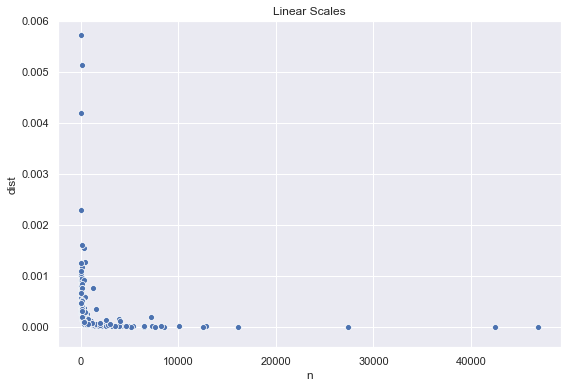

In [7]:
linear_scale = devi.filter(["cod", "n", "dist"])
linear_scale = linear_scale.drop_duplicates()

sns.set( rc={ 'figure.figsize':( 10, 4 ) } )
fig, ax = plt.subplots( figsize=(9,6) )

ax = sns.scatterplot(x="n", y="dist", data=linear_scale)

ax.set_xlabel('n')
ax.set_ylabel('dist')
ax.set_title('Linear Scales')
ax.set( ylim=[ -0.0004 ,0.006 ])


However, the previous plot does not provide much useful information. If the scales are changed to logarithmic, then something more intersting happens. The relation between the sample size and the distance (deviation) is confirmed. But it also can be seen that there are diseases that are far from the **pattern** (tendency line going downwards). 

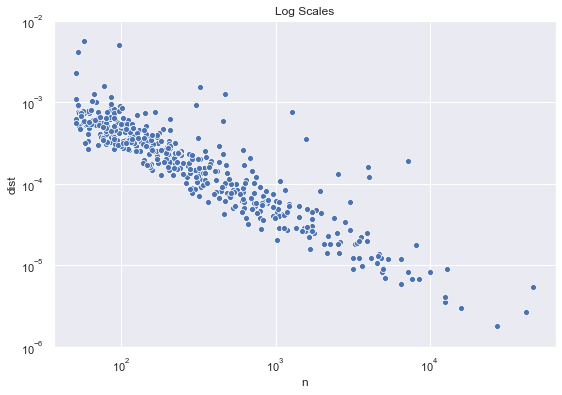

In [8]:

sns.set( rc={ 'figure.figsize':( 10, 4 ) } )
fig, ax = plt.subplots( figsize=(9,6))

ax = sns.scatterplot(x="n", y="dist", data=linear_scale)

ax.set_xlabel('n')
ax.set_ylabel('dist')
ax.set_title('Log Scales')
ax.set( ylim=[ 0.000001,0.01 ])
ax.set_yscale('log')
ax.set_xscale('log')

Just to be clearer, the following plot shows the line that the diseases are following when the sample is increased. The line is computed by the sns library and the method is Robust Linear Regression.  

[(-6, -1)]

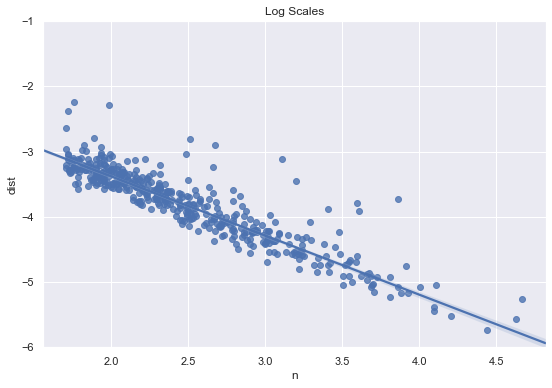

In [12]:
test_dist = linear_scale['dist'].to_numpy()
test_n = linear_scale['n'].to_numpy()

log_dist = np.log10(test_dist)
log_n = np.log10(test_n)


sns.set( rc={ 'figure.figsize':( 10, 4 ) } )
fig, ax = plt.subplots( figsize=(9,6))

ax = sns.regplot(x=log_n, y=log_dist, robust=True);


ax.set_xlabel('n')
ax.set_ylabel('dist')
ax.set_title('Log Scales')
ax.set( ylim=[ -6, -1 ])


As aforementioned, there are diseases that are far from the ***pattern***. To confirm this it is necessary to compute the residuals between the dist and the linear model (which is the ***pattern*** of the diseases as the sample is increased). To make this possible it is used the Huber Regressor from scikit library, which is a Robust Linear Model. Then, the *residual* is computed by the substraction of the real value and the predicted value. 

In [13]:
from sklearn.linear_model import HuberRegressor

x = np.log(devi['n']).values[:, np.newaxis]
y = np.log(devi['dist']).values
model = HuberRegressor()
model.fit(x, y)
devi['residuals'] = y - model.predict(x)

After the residuals are computed, then it is required to visualize the results to see if there is something unusual. The following code generates a plot that shows that some of the diseases are very far from the ***pattern***. 

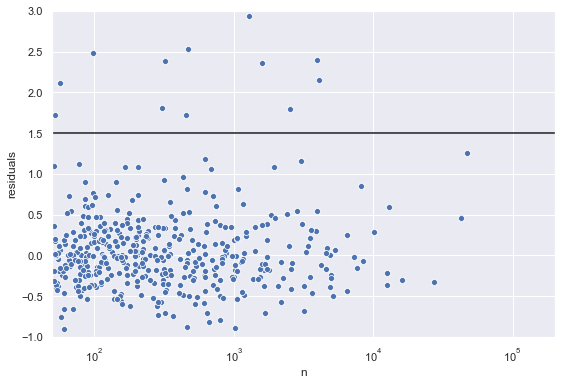

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot(x = 'n', y =  'residuals', data=devi)

ax.set_xscale('log')
ax.set_xlim(50, 200000)
ax.set_ylim(-1, 3)
ax.hlines(1.5, 0, 200000);

# Plots of Unusual Pattern Diseases #

Therefore, it is arbitrarily decided that the residuals above 1.5 are considered unusual. The next piece of code gets the information of the diseases that are above the 1.5 threshold. Besides, the unusual disease are separated in two datasets. The first dataset is for the diseases which sample is above 350 instances and the other dataset is for the rest of the diseases.

In [15]:
#Devi grouping by disease
devi_reduced = devi.drop_duplicates(subset=['cod'])
devi_reduced = devi_reduced[['cod','disease','n','dist','residuals']]

#get the unusual diseases
unusual = devi_reduced[devi_reduced['residuals'] > 1.5]

#get the hod of the unusual diseases
hod_unusual = pd.merge( unusual, grouped[['cod','hod','freq','prop','prop_all']], on = 'cod', how = 'left' )

#split the hod unusual 
hod_unusual_M = hod_unusual[hod_unusual['n'] > 350] # 8 cods
hod_unusual_m = hod_unusual[hod_unusual['n'] < 350] # 5 cods

The next code is used to get the values of each disease from the data set that contains the group of diseases with samples **above 350**.  

In [16]:
#Get the values of each disease, n above 350
temp = hod_unusual_M[ hod_unusual_M['cod'] == 'V09']
temp_sort = temp.sort_values('hod')

temp2 = hod_unusual_M[ hod_unusual_M['cod'] == 'V87']
temp2_sort = temp2.sort_values('hod')

temp3 = hod_unusual_M[ hod_unusual_M['cod'] == 'V89']
temp3_sort = temp3.sort_values('hod')

temp4 = hod_unusual_M[ hod_unusual_M['cod'] == 'W69']
temp4_sort = temp4.sort_values('hod')

temp5 = hod_unusual_M[ hod_unusual_M['cod'] == 'W74']
temp5_sort = temp5.sort_values('hod')

temp6 = hod_unusual_M[ hod_unusual_M['cod'] == 'W87']
temp6_sort = temp6.sort_values('hod')

temp7 = hod_unusual_M[ hod_unusual_M['cod'] == 'X95']
temp7_sort = temp7.sort_values('hod')

temp8 = hod_unusual_M[ hod_unusual_M['cod'] == 'X99']
temp8_sort = temp8.sort_values('hod')

The following code plots each one of the diseases above metioned. Each plot has two lines, one for ***prop*** vs ***hod*** and the other for ***prop_all*** vs ***hod***.

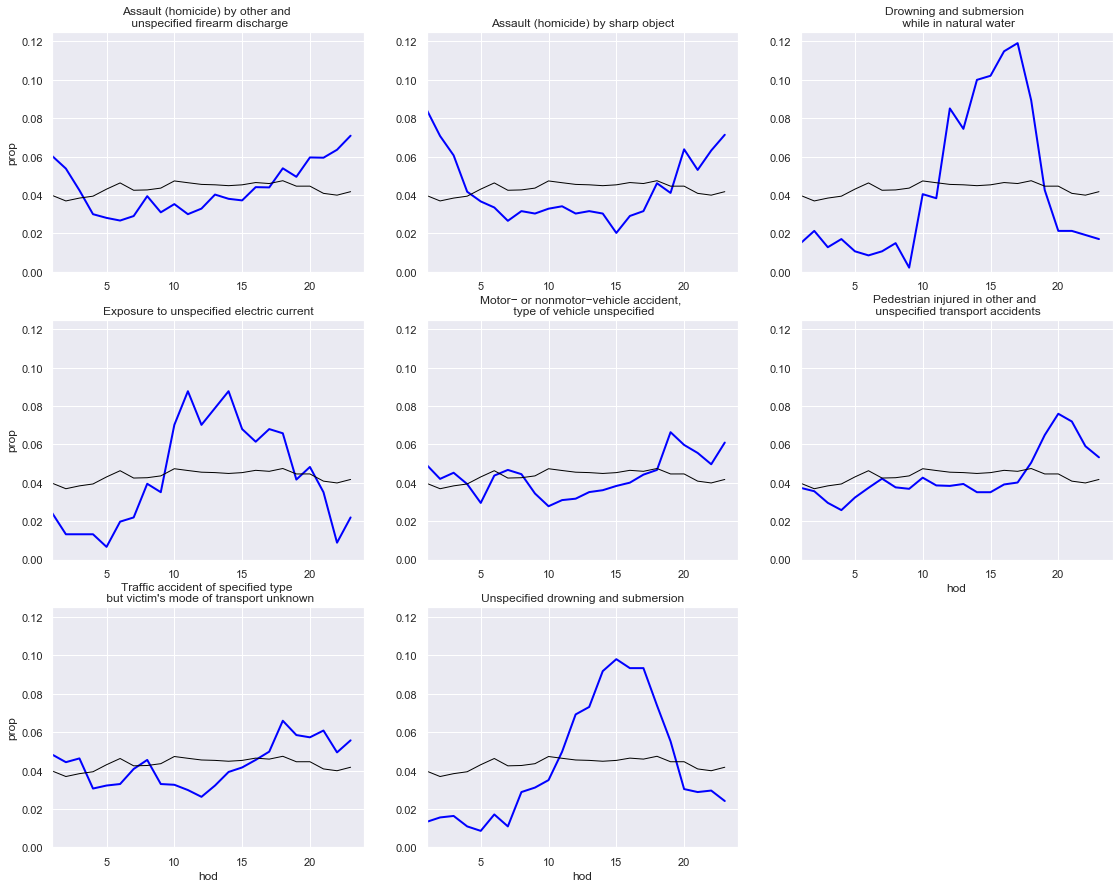

In [17]:
#Plotting
fig=plt.figure(figsize=(19,15))
ax=fig.add_subplot(3,3,6)
ax.plot( temp_sort['hod'] , temp_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp_sort['hod'] , temp_sort['prop_all'], 'r', color='black', linewidth=1)
ax.set_xlabel('hod')
#ax.set_ylabel('prop')
ax.set_title('Pedestrian injured in other and \n unspecified transport accidents')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,7)
ax.plot( temp2_sort['hod'] , temp2_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp2_sort['hod'] , temp2_sort['prop_all'], 'r', color='black', linewidth=1)
ax.set_xlabel('hod')
ax.set_ylabel('prop')
ax.set_title("Traffic accident of specified type \n but victim's mode of transport unknown")
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,5)
ax.plot( temp3_sort['hod'] , temp3_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp3_sort['hod'] , temp3_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod')
#ax.set_ylabel('prop')
ax.set_title('Motor− or nonmotor−vehicle accident, \n type of vehicle unspecified')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,3)
ax.plot( temp4_sort['hod'] , temp4_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp4_sort['hod'] , temp4_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod')
#ax.set_ylabel('prop')
ax.set_title('Drowning and submersion \n while in natural water')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,8)
ax.plot( temp5_sort['hod'] , temp5_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp5_sort['hod'] , temp5_sort['prop_all'], 'r', color='black', linewidth=1)
ax.set_xlabel('hod')
#ax.set_ylabel('prop')
ax.set_title('Unspecified drowning and submersion')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,4)
ax.plot( temp6_sort['hod'] , temp6_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp6_sort['hod'] , temp6_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod')
ax.set_ylabel('prop')
ax.set_title('Exposure to unspecified electric current')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,1)
ax.plot( temp7_sort['hod'] , temp7_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp7_sort['hod'] , temp7_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod')
ax.set_ylabel('prop')
ax.set_title('Assault (homicide) by other and \n unspecified firearm discharge')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(3,3,2)
ax.plot( temp8_sort['hod'] , temp8_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp8_sort['hod'] , temp8_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod')
#ax.set_ylabel('prop')
ax.set_title('Assault (homicide) by sharp object')
ax.set( ylim=[ 0, 0.125])
ax.set( xlim=[ 1, 24])

#plt.savefig('D:/Courses/Machine Learning/HW2/above_350.png')

The next code is used to get the values of each disease from the data set that contains the group of diseases with samples **below 350**.  

In [18]:
#Get the values of each disease, n below 350
temp9 = hod_unusual_m[ hod_unusual_m['cod'] == 'R95']
temp9_sort = temp9.sort_values('hod')

temp10 = hod_unusual_m[ hod_unusual_m['cod'] == 'V79']
temp10_sort = temp10.sort_values('hod')

temp11 = hod_unusual_m[ hod_unusual_m['cod'] == 'V95']
temp11_sort = temp11.sort_values('hod')

temp12 = hod_unusual_m[ hod_unusual_m['cod'] == 'W73']
temp12_sort = temp12.sort_values('hod')

temp13 = hod_unusual_m[ hod_unusual_m['cod'] == 'X33']
temp13_sort = temp13.sort_values('hod')

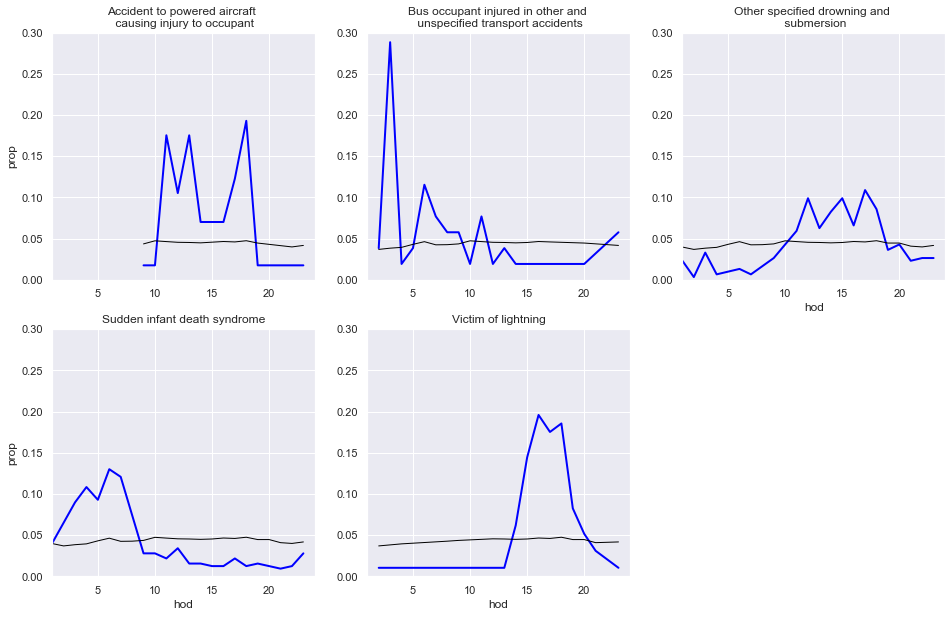

In [20]:
#Plotting
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(2,3,4)
ax.plot( temp9_sort['hod'] , temp9_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp9_sort['hod'] , temp9_sort['prop_all'], 'r', color='black', linewidth=1)
ax.set_xlabel('hod', fontsize=12)
ax.set_ylabel('prop', fontsize=12)
ax.set_title('Sudden infant death syndrome', fontsize=12)
ax.set( ylim=[ 0, 0.3])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(2,3,2)
ax.plot( temp10_sort['hod'] , temp10_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp10_sort['hod'] , temp10_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod', fontsize=12)
#ax.set_ylabel('prop', fontsize=12)
ax.set_title("Bus occupant injured in other and \n unspecified transport accidents", fontsize=12)
ax.set( ylim=[ 0, 0.3])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(2,3,1)
ax.plot( temp11_sort['hod'] , temp11_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp11_sort['hod'] , temp11_sort['prop_all'], 'r', color='black', linewidth=1)
#ax.set_xlabel('hod', fontsize=12)
ax.set_ylabel('prop', fontsize=12)
ax.set_title('Accident to powered aircraft \n causing injury to occupant', fontsize=12)
ax.set( ylim=[ 0, 0.3])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(2,3,3)
ax.plot( temp12_sort['hod'] , temp12_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp12_sort['hod'] , temp12_sort['prop_all'], 'r', color='black', linewidth=1)
ax.set_xlabel('hod', fontsize=12)
#ax.set_ylabel('prop', fontsize=12)
ax.set_title('Other specified drowning and \n submersion', fontsize=12)
ax.set( ylim=[ 0, 0.3])
ax.set( xlim=[ 1, 24])

ax=fig.add_subplot(2,3,5)
ax.plot( temp13_sort['hod'] , temp13_sort['prop'], 'r', color='blue', linewidth=2)
ax.plot( temp13_sort['hod'] , temp13_sort['prop_all'], 'r', color='black', linewidth=1)
ax.set_xlabel('hod', fontsize=12)
#ax.set_ylabel('prop', fontsize=12)
ax.set_title('Victim of lightning', fontsize=12)
ax.set( ylim=[ 0, 0.3])
ax.set( xlim=[ 1, 24])

#plt.savefig('D:/Courses/Machine Learning/HW2/below_350.png')